In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from sklearn.svm import SVC
from shot_based_kernel import BinomialKernel

In [2]:
backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
feature_map = MediumFeatureMap(2,4)
kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=backend)

In [6]:
def load_data(M, margin, seed = 42):
    assert (M <= 2048) & (M % 2 == 0)
    y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
    X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

    np.random.seed(seed)
    indices1 = np.random.randint(0,np.sum(y == 1),M//2)
    indices2 = np.random.randint(0,np.sum(y == -1),M//2)

    X1 = X[y == 1][indices1]
    y1 = y[y == 1][indices1]
    X2 = X[y == -1][indices2]
    y2 = y[y == -1][indices1]

    X12 = np.vstack([X1,X2])
    y12 = np.append(y1,y2)

    shuffle = np.random.choice(M, M, replace=False)
    return X12[shuffle], y12[shuffle]

Text(0, 0.5, 'Kernel error $||K-K_R||_2$')

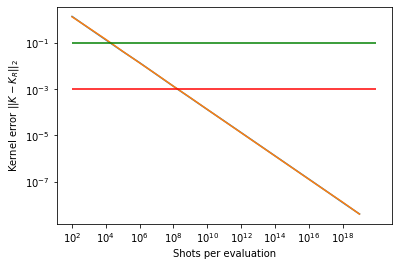

In [41]:
for margin in [0.1,-0.1]:
    X, y = load_data(256, margin)
    K = kernel.evaluate(X)
    K[K > 1] = 1
    K[K < 0] = 0
    shots_kernel = BinomialKernel(K)
    shots = range(2,20)
    eps = np.zeros(18)
    for i, R in enumerate(shots):
        K_noisy = shots_kernel.approximate_kernel(10**R)
        eps[i] = np.linalg.norm(K - K_noisy, ord = 2)
    plt.plot(shots, eps, label=f'Margin {margin}')

plt.yscale('log')
plt.xticks(range(2,20,2),[r'$10^{{%s}}$'%i for i in range(2,20,2)])
plt.hlines([1e-3, 1e-1],2,20,colors=['red','green'])
plt.xlabel('Shots per evaluation')
plt.ylabel(r'Kernel error $||K-K_R||_2$' )

Noisy halfspace?

In [31]:
margin = 0.1
C = 1000

[0.30771396 2.64133914]
[0.57026183 5.76117089]


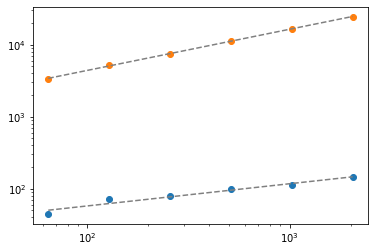

In [36]:
C = 1000
for margin in [0.1, -0.1]:    
    Ms = 2**np.arange(6,12)
    alphas_norm = np.zeros(Ms.shape)

    for i, M in enumerate(Ms):
        X, y = load_data(M, margin)
        K = kernel.evaluate(X)
        svc = SVC(kernel='precomputed', C = C)
        svc.fit(K,y)
        alphas = svc.dual_coef_
        alphas_norm[i] = np.linalg.norm(alphas)

    plt.scatter(Ms, alphas_norm)
    plt.xscale('log')
    plt.yscale('log')
    p = np.polyfit(np.log(Ms), np.log(alphas_norm), 1)
    print(p)
    plt.plot(Ms, np.exp(p[1])*Ms**p[0],'--',color='grey')


[0.22461386 2.31267249]
[0.46509872 1.97856161]


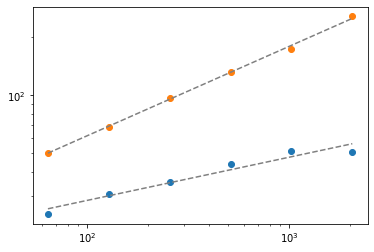

In [37]:
C = 10
for margin in [0.1, -0.1]:    
    Ms = 2**np.arange(6,12)
    alphas_norm = np.zeros(Ms.shape)

    for i, M in enumerate(Ms):
        X, y = load_data(M, margin)
        K = kernel.evaluate(X)
        svc = SVC(kernel='precomputed', C = C)
        svc.fit(K,y)
        alphas = svc.dual_coef_
        alphas_norm[i] = np.linalg.norm(alphas)

    plt.scatter(Ms, alphas_norm)
    plt.xscale('log')
    plt.yscale('log')
    p = np.polyfit(np.log(Ms), np.log(alphas_norm), 1)
    print(p)
    plt.plot(Ms, np.exp(p[1])*Ms**p[0],'--',color='grey')


right SVM?

In [3]:
from SVM import SVM

In [4]:
def get_obj(alphas, K, y, C):
    s1 = np.sum(alphas)
    s2 = -0.5 * (alphas * y) @ K @ (alphas * y).T
    s3 = -0.5/C * np.sum(alphas**2)
    return s1 + s2 + s3

def get_obj2(alphas, K, y, C):
    s1 = np.sum(alphas)
    s2 = 0.5 * (alphas * y) @ K @ (alphas * y).T
    return s2 - s1

In [8]:
margin = -0.1
C = 1000
for s in np.random.randint(0,100000,10):
    for b in [True, False]:
        X, y = load_data(100, margin, s)
        K = kernel.evaluate(X)

        svc = SVM(kernel='precomputed', C=C, verbose=True, cut_near_zeros = b)
        svc.fit(K, y)
        alphas = svc._alphas

        print("Objectives: ", get_obj(alphas, K, y, C), get_obj2(alphas, K, y, 10))
        input()

Quadratic program solved
Training accuracy:  0.89
Objective:  -13106.730742513784
Support vectors:  35
Objectives:  13106.730742514736 -25950.528127906353
Quadratic program solved
Training accuracy:  0.89
Objective:  -13106.730742513784
Support vectors:  99
Objectives:  13106.730742514135 -25950.528127905753
Quadratic program solved
Training accuracy:  0.98
Objective:  -5988.00179902124
Support vectors:  24
Objectives:  5988.001799019758 -10395.049575786055
Quadratic program solved
Training accuracy:  0.98
Objective:  -5988.00179902124
Support vectors:  99
Objectives:  5988.001799019347 -10395.049575785644
Quadratic program solved
Training accuracy:  0.93
Objective:  -8520.757619144393
Support vectors:  29
Objectives:  8520.757619143835 -16507.627535251067
Quadratic program solved
Training accuracy:  0.93
Objective:  -8520.757619144393
Support vectors:  99
Objectives:  8520.757619143624 -16507.627535250856
Quadratic program solved
Training accuracy:  0.92
Objective:  -11095.04869902712

In [7]:
alphas

array([-8.32616078e-14,  5.25114235e+02, -7.38456152e-14,  1.83366578e+03,
        8.00218452e+02,  8.31653299e-15,  2.78222794e+02,  8.24480796e+02,
        2.56781435e+02,  3.80500301e-13,  5.72359722e-14,  7.71681710e+02,
        1.28321816e+03,  4.95887221e+02, -7.80749656e-15,  5.13449687e+02,
       -5.20694240e-15,  3.17930325e+02,  4.85826660e-14,  1.24589310e+03,
       -1.68078305e-13,  7.04089289e-14,  9.04664052e+02,  5.66024409e+02,
        4.89852606e+02, -5.64319849e-14,  8.53698988e-14, -1.43513059e-13,
        5.68576930e+02,  9.21985833e-14,  8.00667482e+02,  6.75173287e+02,
        5.83435910e-14,  8.38719418e-14,  1.38722268e-13,  1.91188267e+02,
       -4.47843005e-14, -2.66964775e-13, -2.61086822e-13,  3.81009896e-14,
        3.49531857e+02,  9.61147771e+02,  3.01165897e-13,  3.49531857e+02,
       -1.44509627e-14,  6.65162950e+02,  1.03847402e+03,  5.23889585e+02,
        1.26287927e+03, -2.43280108e-14, -2.65962356e-13,  5.07152234e+02,
        3.32683203e+02, -